In [7]:
import glob
import numpy as np
import pandas as pd

import scipy
import sklearn
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew, kurtosis

In [8]:
class Extract_Time_Features:    
    def __init__(self, rawTimeData):
        self._TimeFeatures = []
        self._rawTimeData = rawTimeData

    def AbsMax(self):
        self._absmax = np.abs(self._rawTimeData).max(axis=1)
        return self._absmax
    
    def AbsMean(self):
        self._absmean = np.abs(self._rawTimeData).mean(axis=1)
        return self._absmean
    
    def P2P(self):
        self._peak2peak = np.max(self._rawTimeData,axis=1) - np.min(self._rawTimeData,axis=1)
        return self._peak2peak 
    
    def Skewness(self):
        self._skewness = skew(self._rawTimeData, axis=1, nan_policy='raise')
        return self._skewness
    
    def Kurtosis(self):
        self._kurtosis = kurtosis(self._rawTimeData, axis=1, fisher=False)
        return self._kurtosis

    def RMS(self):
        self._rms = np.sqrt(np.sum(self._rawTimeData**2, axis=1) / self._rawTimeData.shape[1])
        return self._rms
    
    def CrestFactor(self):
        self._cresfactor = self.P2P() / self.RMS()
        return self._cresfactor
    
    def ShapeFactor(self):
        self._shapefactor = self.RMS() / self.AbsMean()
        return self._shapefactor
    
    def ImpulseFactor(self):
        self._impulsefactor = self.AbsMax() / self.AbsMean()
        return self._impulsefactor

    def Features(self):
        # Time-domain Features #
        self._TimeFeatures.append(self.AbsMax())        # Feature 1: Absolute Maximum 
        self._TimeFeatures.append(self.AbsMean())       # Feature 2: Absolute Mean
        self._TimeFeatures.append(self.P2P())           # Feature 3: Peak-to-Peak
        self._TimeFeatures.append(self.RMS())           # Feature 4: Root-mean-square
        self._TimeFeatures.append(self.Skewness())      # Feature 5: Skewness
        self._TimeFeatures.append(self.Kurtosis())      # Feature 6: Kurtosis
        self._TimeFeatures.append(self.CrestFactor())   # Feature 7: Crest Factor
        self._TimeFeatures.append(self.ShapeFactor())   # Feature 8: Shape Factor
        self._TimeFeatures.append(self.ImpulseFactor()) # Feature 9: Impulse Factor
                
        return np.asarray(self._TimeFeatures)

In [9]:
class Extract_Freq_Features:    
    def __init__(self, rawTimeData, rpm, Fs):
        self._FreqFeatures = []
        # Remove bias (subtract mean by each channel) #
        self._rawTimeData = rawTimeData - np.expand_dims(np.mean(rawTimeData,axis=1),axis=1) # Raw time data
        
        self._Fs = Fs                    # Sampling frequency [Hz]
        self._rpm = rpm/60               # RPM for every second [Hz]
       
    def FFT(self):
        # Perform FFT #
        _N = self._rawTimeData.shape[1]
        _dt = 1/self._Fs
        _yf_temp = np.fft.fft(self._rawTimeData)
        self._yf = np.abs(_yf_temp[:,:int(_N/2)]) / (_N/2)
        self._xf = np.fft.fftfreq(_N, d=_dt)[:int(_N/2)]
        
        return self._xf, self._yf
    
    def Freq_IDX(self):
        _xf,_yf = self.FFT()
        
        # Motor #
        # find frequency index of 1x #
        self._Freq_1x = self._rpm
        self._1x_idx_Temp = abs(_xf - self._Freq_1x).argmin()
        self._1x_idx_Temp = self._1x_idx_Temp - 2 + np.argmax(self._yf[0][np.arange(self._1x_idx_Temp-2, self._1x_idx_Temp+3)])
        self._1x_idx = np.arange(self._1x_idx_Temp-1, self._1x_idx_Temp+2)

        # find frequency index of 2x #
        self._Freq_2x = self._xf[self._1x_idx[1]] * 2
        self._2x_idx_Temp = abs(_xf - self._Freq_2x).argmin()
        self._2x_idx_Temp = self._2x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._2x_idx_Temp-5, self._2x_idx_Temp+6)])
        self._2x_idx = np.arange(self._2x_idx_Temp-1, self._2x_idx_Temp+2)
        
        # find frequency index of 3x #
        self._Freq_3x = self._xf[self._1x_idx[1]] * 3
        self._3x_idx_Temp = abs(_xf - self._Freq_3x).argmin()
        self._3x_idx_Temp = self._3x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._3x_idx_Temp-5, self._3x_idx_Temp+6)])
        self._3x_idx = np.arange(self._3x_idx_Temp-1, self._3x_idx_Temp+2)
        
        # find frequency index of 4x #
        self._Freq_4x = self._xf[self._1x_idx[1]]  * 4
        self._4x_idx_Temp = abs(_xf - self._Freq_4x).argmin()
        self._4x_idx_Temp = self._4x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._4x_idx_Temp-5, self._4x_idx_Temp+6)])
        self._4x_idx = np.arange(self._4x_idx_Temp-1, self._4x_idx_Temp+2)
        
        # Belt #
        # find frequency index of 1x #
        self._Freq_1x_B = self._Freq_1x - 5
        self._1x_idx_B_Temp = abs(_xf - self._Freq_1x_B).argmin()
        self._1x_idx_B_Temp = self._1x_idx_B_Temp - 2 + np.argmax(self._yf[0][np.arange(self._1x_idx_B_Temp-2, self._1x_idx_B_Temp+3)])
        self._1x_idx_B = np.arange(self._1x_idx_B_Temp-1, self._1x_idx_B_Temp+2)

        # find frequency index of 2x #
        self._Freq_2x_B = self._xf[self._1x_idx_B[1]] * 2
        self._2x_idx_B_Temp = abs(_xf - self._Freq_2x_B).argmin()
        self._2x_idx_B_Temp = self._2x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._2x_idx_B_Temp-5, self._2x_idx_B_Temp+6)])
        self._2x_idx_B = np.arange(self._2x_idx_B_Temp-1, self._2x_idx_B_Temp+2)
        
        # find frequency index of 3x #
        self._Freq_3x_B = self._xf[self._1x_idx_B[1]] * 3
        self._3x_idx_B_Temp = abs(_xf - self._Freq_3x_B).argmin()
        self._3x_idx_B_Temp = self._3x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._3x_idx_B_Temp-5, self._3x_idx_B_Temp+6)])
        self._3x_idx_B = np.arange(self._3x_idx_B_Temp-1, self._3x_idx_B_Temp+2)
        
        # find frequency index of 4x #
        self._Freq_4x_B = self._xf[self._1x_idx_B[1]] * 4
        self._4x_idx_B_Temp = abs(_xf - self._Freq_4x_B).argmin()
        self._4x_idx_B_Temp = self._4x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._4x_idx_B_Temp-5, self._4x_idx_B_Temp+6)])
        self._4x_idx_B = np.arange(self._4x_idx_B_Temp-1, self._4x_idx_B_Temp+2)
        
        
        return (self._1x_idx, self._2x_idx, self._3x_idx, self._4x_idx,
                self._1x_idx_B, self._2x_idx_B, self._3x_idx_B, self._4x_idx_B)

    def Features(self):
        _xf, _yf = self.FFT()
        idx = self.Freq_IDX()
                
        # Freq-domain Features #
        self._1x_Feature = np.sum(_yf[:, idx[0]], axis=1) 
        self._2x_Feature = np.sum(_yf[:, idx[1]], axis=1) 
        self._3x_Feature = np.sum(_yf[:, idx[2]], axis=1) 
        self._4x_Feature = np.sum(_yf[:, idx[3]], axis=1)
        self._1x_Feature_B = np.sum(_yf[:, idx[4]], axis=1) 
        self._2x_Feature_B = np.sum(_yf[:, idx[5]], axis=1) 
        self._3x_Feature_B = np.sum(_yf[:, idx[6]], axis=1) 
        self._4x_Feature_B = np.sum(_yf[:, idx[7]], axis=1) 
                
        self._FreqFeatures.append(self._1x_Feature)
        self._FreqFeatures.append(self._2x_Feature)
        self._FreqFeatures.append(self._3x_Feature)
        self._FreqFeatures.append(self._4x_Feature)
        self._FreqFeatures.append(self._1x_Feature_B)
        self._FreqFeatures.append(self._2x_Feature_B)
        self._FreqFeatures.append(self._3x_Feature_B)
        self._FreqFeatures.append(self._4x_Feature_B)
        
        return np.asarray(self._FreqFeatures)

In [10]:
def validation(filename):
    vib = pd.read_csv(filename, header=None, skiprows=9)
    vib = np.asarray(vib)[:,1:-1].transpose()

    date = pd.read_csv(filename, header=None, skiprows=0, nrows=1)
    date = date[1]

    meta = pd.read_csv(filename, header=None, skiprows=4, nrows=1)
    rpm = int(meta[2])

    fs = pd.read_csv(filename, header=None, skiprows=6, nrows=1)
    Fs = int(fs[1])

    TimeFeatureExtractor = Extract_Time_Features(vib)
    features_time = TimeFeatureExtractor.Features().flatten()

    FreqFeatureExtractor = Extract_Freq_Features(vib, rpm, Fs)
    features_freq = FreqFeatureExtractor.Features().flatten()

    y = pd.read_csv(filename, header=None, skiprows=3, nrows=1)
    y = y[1]
    
    vib_dataset = np.concatenate((date, features_time, features_freq, meta[3], y))

    return vib_dataset

# Vibration Normal 

In [21]:
datapath = glob.glob("C:/Users/qhrrl/CodeExamples/current_ai/vibration/" + '**/*.csv', recursive=True)

In [22]:
len(datapath)

24487

In [23]:
datapath

['C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163909_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163915_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163918_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163921_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163939_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163942_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163945_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_163948_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration\\L-DSF-01\\정상

In [29]:
vib_dataset_list = []

for file in datapath:
    dataset = validation(file)
    vib_dataset_list.append(dataset)

In [30]:
vib_dataset = pd.DataFrame(vib_dataset_list)

In [31]:
vib_dataset.columns = [ 'Date',
    'AbsMax', 'AbsMean', 'P2P', 'RMS', 'Skewness', 'Kurtosis', 'Crest', 
    'Shape', 'Impulse','1x', '2x', '3x', '4x', '1xB', '2xB', '3xB', '4xB',
               'WATT', 'LABEL']

In [32]:
vib_dataset

,Date,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB,WATT,LABEL
0,2020-11-25 16:39:09,0.052886,0.004459,0.071972,0.005718,-0.438530,4.491689,12.587725,1.282149,11.859366,0.001678,0.002248,0.001469,0.002217,0.000414,0.000677,0.000280,0.000264,2.2,0
1,2020-11-25 16:39:15,0.045940,0.004400,0.065973,0.005704,-0.610259,5.239334,11.566962,1.296319,10.441389,0.002351,0.001282,0.001054,0.002149,0.001089,0.000716,0.000539,0.000422,2.2,0
2,2020-11-25 16:39:18,0.065577,0.004383,0.083307,0.005693,-0.770679,7.921089,14.634132,1.298942,14.963328,0.001837,0.001834,0.000904,0.002094,0.000756,0.000304,0.000474,0.000251,2.2,0
3,2020-11-25 16:39:21,0.035403,0.004476,0.055008,0.005706,-0.370442,3.892957,9.640617,1.274830,7.909952,0.001693,0.001862,0.000947,0.002018,0.000523,0.000722,0.000441,0.000551,2.2,0
4,2020-11-25 16:39:39,0.051636,0.004399,0.071079,0.005662,-0.531653,4.878760,12.554092,1.287100,11.738523,0.002094,0.001904,0.000737,0.002092,0.000407,0.000812,0.000402,0.000340,2.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24482,2020-12-22 11:04:38,0.052547,0.004740,0.074699,0.005988,-0.196832,4.054446,12.474992,1.263368,11.086796,0.001835,0.000897,0.000623,0.001543,0.000453,0.000397,0.000342,0.000270,2.2,3
24483,2020-12-22 11:05:02,0.062458,0.004646,0.085760,0.005916,-0.379343,6.307507,14.496142,1.273443,13.444110,0.001961,0.000879,0.000631,0.001744,0.000257,0.000516,0.000340,0.000379,2.2,3
24484,2020-12-22 11:05:50,0.080816,0.004649,0.101355,0.005921,-0.443363,7.581394,17.116650,1.273798,17.384850,0.002033,0.000893,0.000367,0.001492,0.000255,0.000684,0.000389,0.000258,2.2,3
24485,2020-12-22 11:06:50,0.084580,0.004533,0.105602,0.005813,-0.517300,8.422056,18.165707,1.282326,18.657220,0.002017,0.000852,0.000695,0.001558,0.000299,0.000830,0.000405,0.000252,2.2,3


In [34]:
len(vib_dataset)

24487

<AxesSubplot:xlabel='LABEL', ylabel='count'>

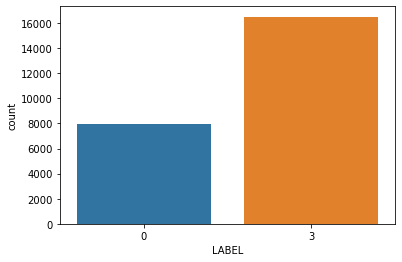

In [33]:
import seaborn as sns

sns.countplot(x='LABEL', data=vib_dataset)

In [36]:
vib_dataset.to_csv('2.2kW_vib_L-DSF-01_training_with_label.csv', index=False)

# Vibration validation

In [4]:
datapath = glob.glob("C:/Users/qhrrl/CodeExamples/current_ai/vibration_val/" + '**/*.csv', recursive=True)

In [5]:
datapath

['C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141245_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141248_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141251_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141257_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141300_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141303_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141309_004.csv',
 'C:/Users/qhrrl/CodeExamples/current_ai/vibration_val\\L-DSF-01\\정상\\STFMK-20201105-LW15-2055_20201125_141312_004.csv',
 'C:/Users/qhrrl/CodeExamples/cu

In [6]:
len(datapath)

3064

In [11]:
vib_dataset_list_val = []

for file in datapath:
    val_dataset = validation(file)
    vib_dataset_list_val.append(val_dataset)

In [12]:
len(vib_dataset_list_val)

3064

In [13]:
pd_vib_dataset = pd.DataFrame(vib_dataset_list_val)
pd_vib_dataset.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2020-11-25 14:12:45,0.034602,0.004536,0.059844,0.005795,-0.346551,3.739838,10.327648,1.277342,7.627640,0.002133,0.001284,0.002141,0.001428,0.000340,0.000634,0.000463,0.000308,2.2,0
1,2020-11-25 14:12:48,0.040246,0.004503,0.061607,0.005761,-0.307192,3.920466,10.694190,1.279235,8.937029,0.002219,0.001125,0.001391,0.001427,0.000421,0.000655,0.000349,0.000160,2.2,0
2,2020-11-25 14:12:51,0.041396,0.004518,0.061573,0.005757,-0.272229,3.788825,10.694504,1.274383,9.162781,0.002417,0.000946,0.001131,0.001097,0.000266,0.000540,0.000176,0.000516,2.2,0


In [14]:
pd_vib_dataset.columns = [ 'Date',
    'AbsMax', 'AbsMean', 'P2P', 'RMS', 'Skewness', 'Kurtosis', 'Crest', 
    'Shape', 'Impulse','1x', '2x', '3x', '4x', '1xB', '2xB', '3xB', '4xB',
               'WATT', 'LABEL']

In [15]:
pd_vib_dataset.head(3)

,Date,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB,WATT,LABEL
0,2020-11-25 14:12:45,0.034602,0.004536,0.059844,0.005795,-0.346551,3.739838,10.327648,1.277342,7.627640,0.002133,0.001284,0.002141,0.001428,0.000340,0.000634,0.000463,0.000308,2.2,0
1,2020-11-25 14:12:48,0.040246,0.004503,0.061607,0.005761,-0.307192,3.920466,10.694190,1.279235,8.937029,0.002219,0.001125,0.001391,0.001427,0.000421,0.000655,0.000349,0.000160,2.2,0
2,2020-11-25 14:12:51,0.041396,0.004518,0.061573,0.005757,-0.272229,3.788825,10.694504,1.274383,9.162781,0.002417,0.000946,0.001131,0.001097,0.000266,0.000540,0.000176,0.000516,2.2,0


<AxesSubplot:xlabel='LABEL', ylabel='count'>

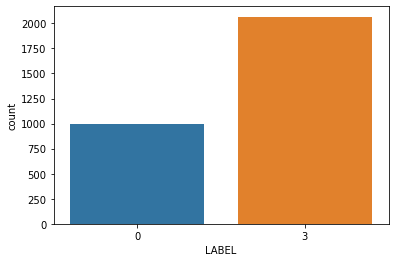

In [16]:
import seaborn as sns

sns.countplot(x='LABEL', data=pd_vib_dataset)

In [17]:
pd_vib_dataset.to_csv('2.2kW_vib_L-DSF-01_validation_with_label.csv', index=False)

# 데이터 추출 이후

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
data_all = pd.read_csv('C:/Users/qhrrl/CodeExamples/current_ai/2.2kW전체.csv')

In [4]:
data_all.head(5)

,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,...,T_1x,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x
0,3.403320,3.123047,4.043945,2.057587,1.889543,2.245951,6.726562,6.166016,7.607422,2.296682,...,0.014614,3.282771,3.058104,3.579351,0.022117,0.019693,0.023455,0.031669,0.027953,0.024256
1,3.283203,3.083008,4.003906,2.059709,1.883498,2.254960,6.526367,6.005859,7.487305,2.287841,...,0.015374,3.433224,3.183656,3.761500,0.013864,0.011091,0.014099,0.030992,0.039196,0.035626
2,3.283203,3.083008,3.963867,2.059209,1.884539,2.255280,6.526367,6.085938,7.407227,2.288444,...,0.019783,3.432319,3.184894,3.755824,0.022333,0.019714,0.020837,0.024400,0.026358,0.023356
3,3.283203,3.123047,3.963867,2.065936,1.881936,2.254640,6.526367,6.085938,7.407227,2.295448,...,0.021853,3.448775,3.188166,3.774974,0.020763,0.018589,0.020160,0.021301,0.024387,0.022983
4,3.363281,3.163086,3.963867,2.063974,1.901255,2.222268,6.686523,6.206055,7.407227,2.293941,...,0.010843,3.317691,3.091339,3.568165,0.012395,0.012090,0.013433,0.016602,0.018446,0.015287


In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367680 entries, 0 to 367679
Data columns (total 45 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_AbsMax    367680 non-null  float64
 1   S_AbsMax    367680 non-null  float64
 2   T_AbsMax    367680 non-null  float64
 3   R_AbsMean   367680 non-null  float64
 4   S_AbsMean   367680 non-null  float64
 5   T_AbsMean   367680 non-null  float64
 6   R_P2P       367680 non-null  float64
 7   S_P2P       367680 non-null  float64
 8   T_P2P       367680 non-null  float64
 9   R_RMS       367680 non-null  float64
 10  S_RMS       367680 non-null  float64
 11  T_RMS       367680 non-null  float64
 12  R_Skewness  367680 non-null  float64
 13  S_Skewness  367680 non-null  float64
 14  T_Skewness  367680 non-null  float64
 15  R_Kurtosis  367680 non-null  float64
 16  S_Kurtosis  367680 non-null  float64
 17  T_Kurtosis  367680 non-null  float64
 18  R_Crest     367680 non-null  float64
 19  S_

In [6]:
data_all.describe()

,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,...,T_1x,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x
count,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,...,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000,367680.000000
mean,3.342085,3.158495,4.041460,2.070947,1.886200,2.275587,6.643170,6.215305,7.558240,2.312241,...,0.012766,3.315178,3.045715,3.643800,0.019074,0.017324,0.019203,0.037652,0.037562,0.038341
std,0.314755,0.304590,0.332479,0.136908,0.123365,0.140491,0.545680,0.563636,0.547717,0.153927,...,0.008147,0.466758,0.429069,0.515456,0.013217,0.012468,0.013020,0.026402,0.023580,0.026072
min,0.040039,0.135132,0.090088,0.000300,0.002342,0.000741,0.040039,0.160156,0.040039,0.005297,...,0.000394,0.000219,0.001012,0.000425,0.000254,0.000853,0.000543,0.000226,0.000861,0.000475
25%,3.293213,3.123047,3.998901,2.068673,1.878783,2.263929,6.566406,6.166016,7.487305,2.309915,...,0.009877,3.315578,3.045660,3.641517,0.012913,0.011629,0.012764,0.025045,0.026252,0.025746
50%,3.358276,3.163086,4.043945,2.088550,1.897366,2.296460,6.686523,6.246094,7.567383,2.335328,...,0.011722,3.379604,3.100613,3.719359,0.015368,0.013872,0.015309,0.030824,0.031621,0.031730
75%,3.398315,3.203125,4.124023,2.104373,1.913397,2.318555,6.726562,6.326172,7.727539,2.353518,...,0.014503,3.443466,3.159309,3.792365,0.019270,0.017508,0.019696,0.037407,0.037754,0.037816
max,46.565430,47.085938,45.484375,2.569136,2.587745,2.566824,69.307617,81.039062,50.128906,2.854566,...,1.298812,4.193345,4.362730,4.486734,1.130485,1.135844,0.852168,0.889722,0.925318,0.545237


In [13]:
data_all['R_AbsMax'].unique()
#num6["설비명"].unique(),num6["품목군"].unique(), num6["금형코드"].unique(),num6["품목코드"].unique(),num6["품목정보"].unique()
# 주요 범주형 데이터에 대한 정보를 확인

array([3.40332031e+00, 3.28320312e+00, 3.36328125e+00, 3.24316406e+00,
       3.20312500e+00, 3.32324219e+00, 3.48339844e+00, 3.16308594e+00,
       3.44335938e+00, 3.56347656e+00, 3.37829590e+00, 3.38830566e+00,
       3.39331055e+00, 3.37329102e+00, 3.38330078e+00, 3.35327148e+00,
       3.33325195e+00, 3.34326172e+00, 3.31323242e+00, 3.30322266e+00,
       3.49340820e+00, 3.51342773e+00, 3.53344727e+00, 3.52343750e+00,
       3.50341797e+00, 3.54345703e+00, 3.43334961e+00, 3.34826660e+00,
       3.46838379e+00, 3.47338867e+00, 3.46337891e+00, 3.22814941e+00,
       3.26818848e+00, 3.27319336e+00, 3.23315430e+00, 3.33825684e+00,
       3.45837402e+00, 3.45336914e+00, 3.41833496e+00, 3.41333008e+00,
       3.42333984e+00, 3.50842285e+00, 3.55346680e+00, 3.42834473e+00,
       3.26318359e+00, 3.25317383e+00, 3.29821777e+00, 3.29321289e+00,
       3.30822754e+00, 3.21313477e+00, 3.25817871e+00, 3.27819824e+00,
       3.19311523e+00, 3.18310547e+00, 3.22314453e+00, 3.23815918e+00,
      

<Figure size 1080x1440 with 0 Axes>

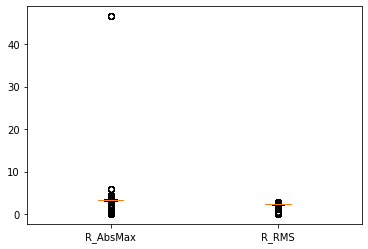

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,20)) # 불량률에 대한 Boxplot --- 데이터 분포 확인 및 이상치 제거 기준 확립
fig, ax = plt.subplots()
ax.boxplot([data_all["R_AbsMax"], data_all["R_RMS"]])
plt.xticks([1,2],['R_AbsMax', 'R_RMS'])
plt.show()

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

<Figure size 1440x1440 with 0 Axes>

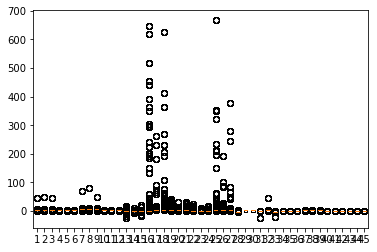

In [20]:
plt.figure(figsize=(20,20)) # 불량률에 대한 Boxplot --- 데이터 분포 확인 및 이상치 제거 기준 확립
fig, ax = plt.subplots()
ax.boxplot(data_all)
plt.xticks(data_all)
plt.show()

In [ ]:
sns.countplot(x='LABEL', data=current_all_with_label) # 라벨 달린애들 csv 따로 구해서 라벨값 분포 갯수 구해보기

In [23]:
import matplotlib.pyplot as plt

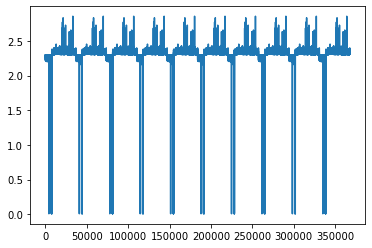

In [24]:
plt.plot(pd_feature['R_RMS'])

In [12]:
string  = 'STFCB-20201012-0105-0137_20201104_121505_002.csv'

In [17]:
st = string[10:-4]

In [18]:
st

'1012-0105-0137_20201104_121505_002.'